Currently on experiment 0


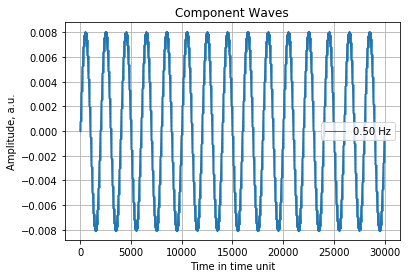

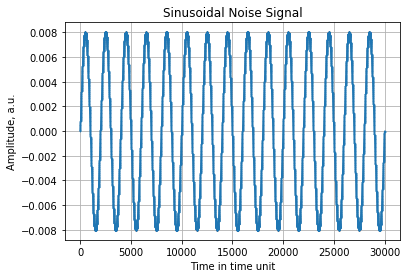

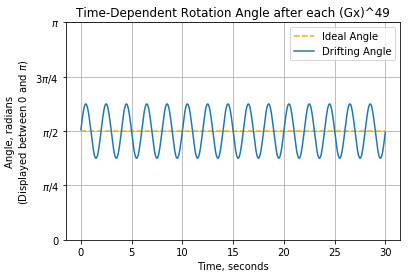

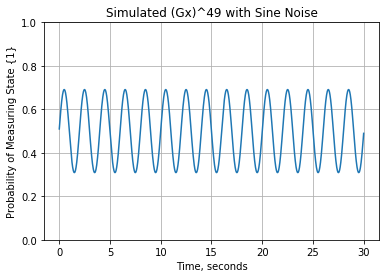

Currently on experiment 1


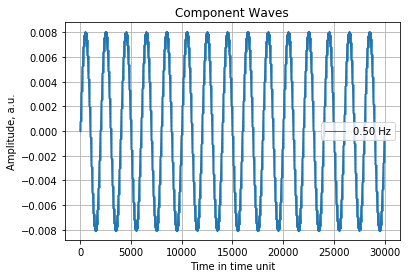

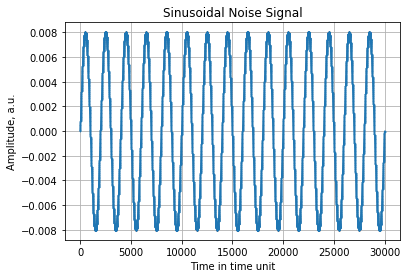

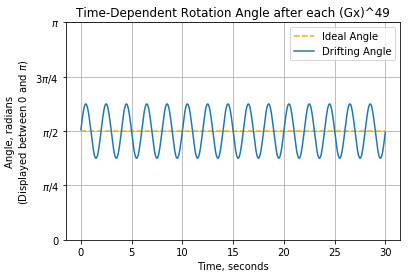

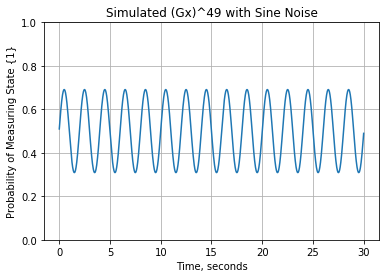

Currently on experiment 2


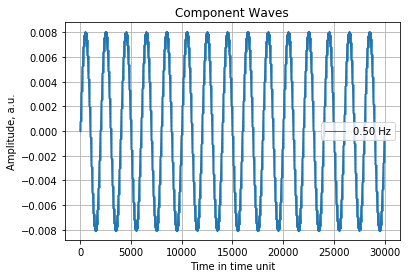

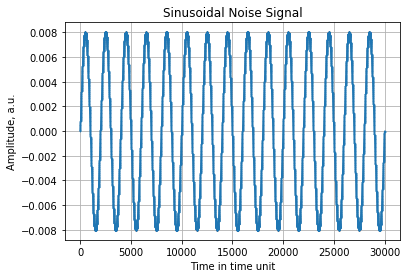

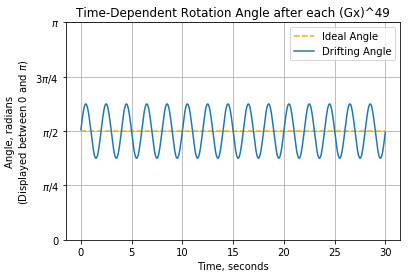

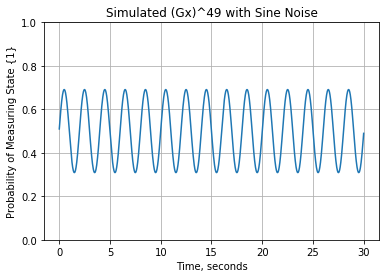

Currently on experiment 0


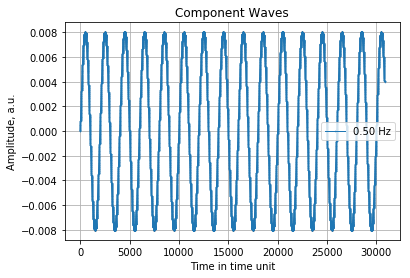

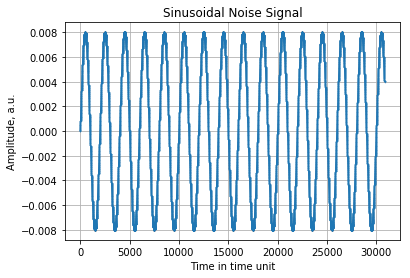

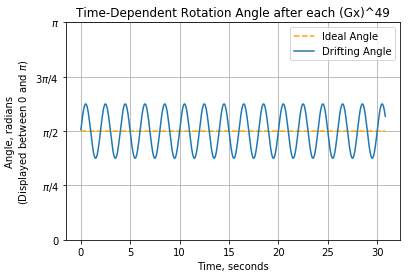

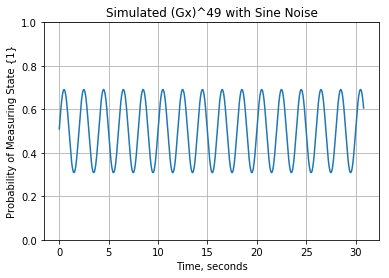

Currently on experiment 1


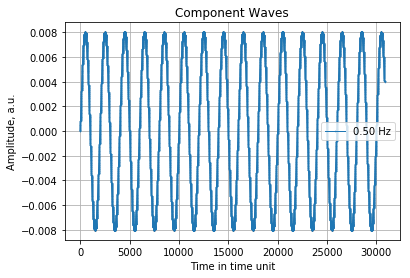

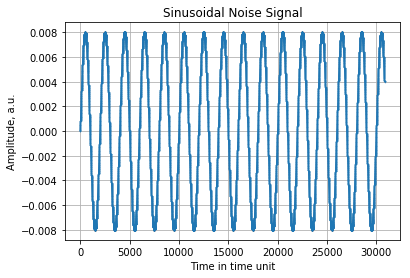

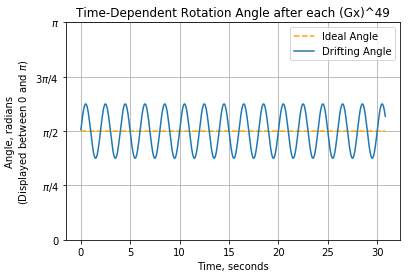

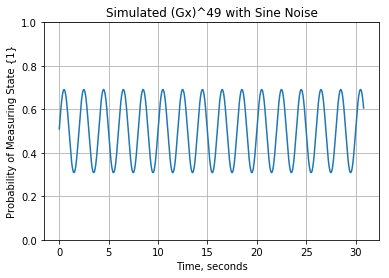

Currently on experiment 2


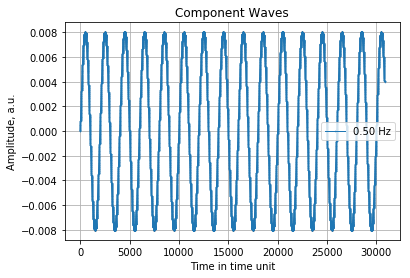

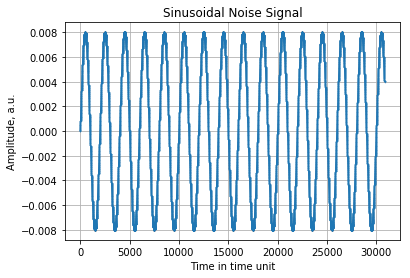

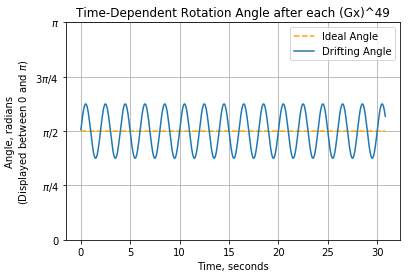

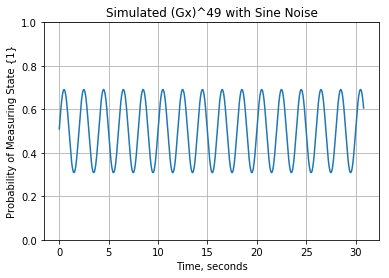

Currently on experiment 0


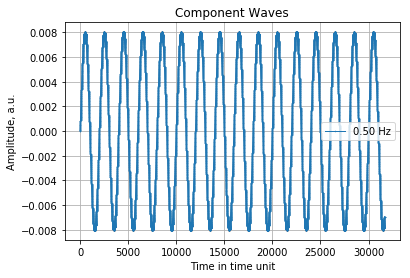

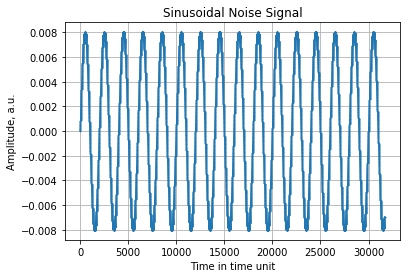

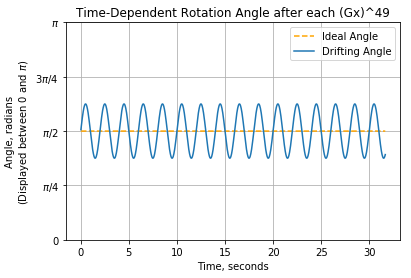

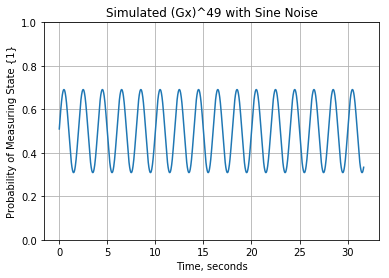

Currently on experiment 1


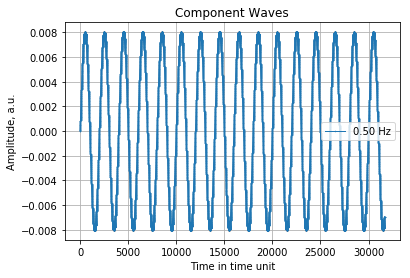

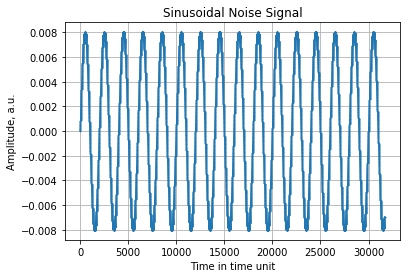

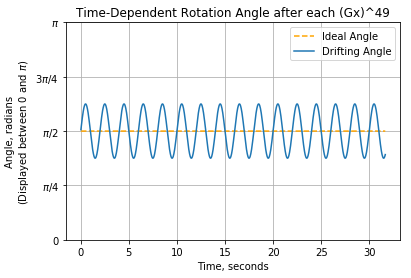

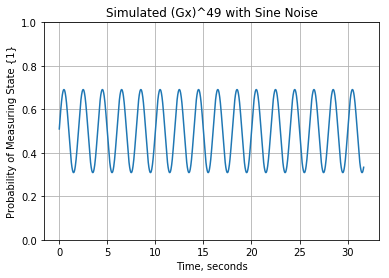

Currently on experiment 2


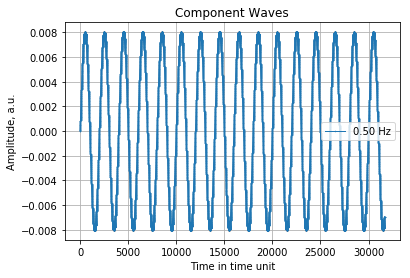

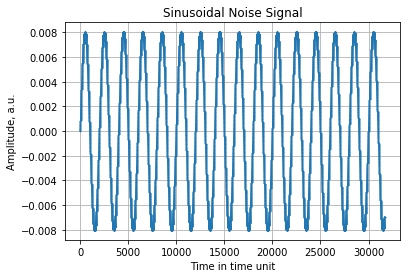

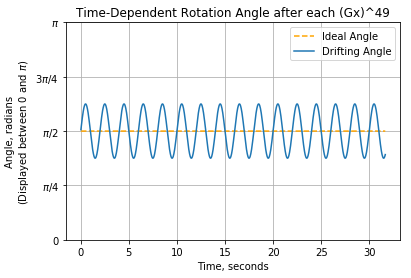

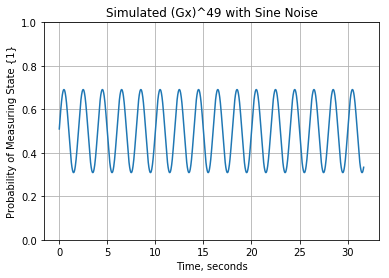

Currently on experiment 0


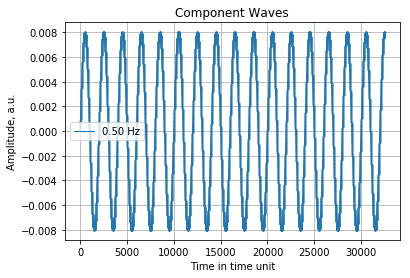

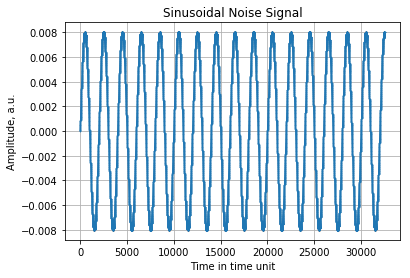

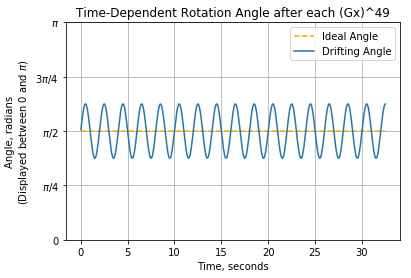

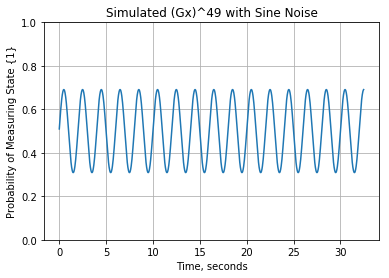

Currently on experiment 1


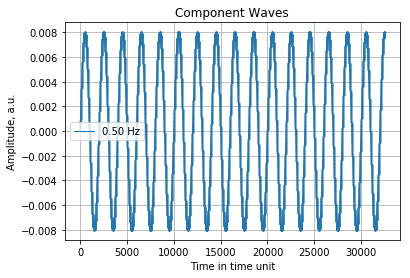

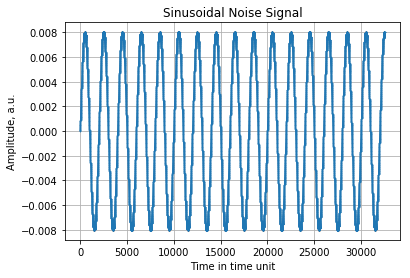

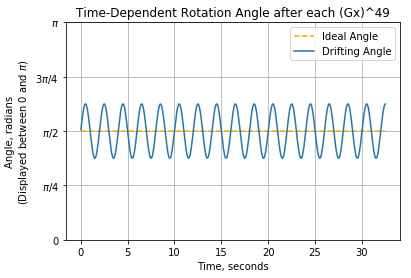

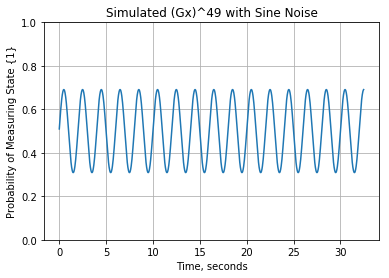

Currently on experiment 2


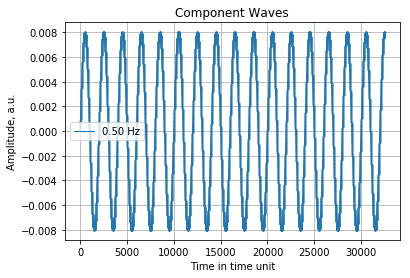

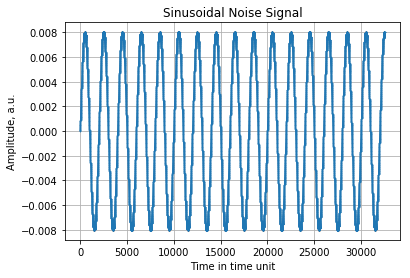

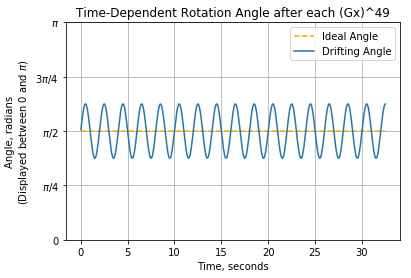

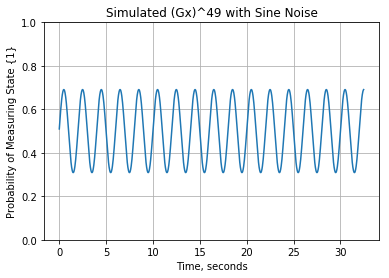

In [9]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data, gate_string_to_list, gate_list_to_string, SNR, find_max_power, find_band_power

#################################################################################################################
gate_string = "(Gx)^49"
nSamples = 2000  #total samples to take for each measurement
nCounts = 1   #total shots to take at one; =nSamples: same noise, probabilities for all repeats; =1, new experiment & noise for each count
time_per_count = 1/60 #seconds
time_units = 1e-3 #seconds. This should be the max resolution you expect to input at any given time (i.e. everthing on the scale of 1e-3 s or more)
res = 1
noise_type='Sine' #Sine, Random Walk, Telegraph
plot_noise=True
walking_amp = 0.0001
low_frequency_noise = [np.round(0.0015*i, 4) for i in range(5)]
low_frequency_noise = [] #uncomment this to eliminate low_frequency noise
low_frequency_amps = [0.005*i for i in range(len(low_frequency_noise))]
low_frequency_phase = [0]*len(low_frequency_noise)
freq_list=[0.5]#1.2, 6, 8.4, 9.6] + low_frequency_noise
amp_list=[0.008]#0.002, 0.002, 0.0015, 0.0015] + low_frequency_amps
phase_list=[0]#,0,0,0] + low_frequency_phase
telegraph_amp = 0.02
start_f = 0.1
stop_f = 2
fluctuators= 40
add_noise=None#0.001

num_experiments = 3 #how many times you want to run a single set of parameters
variable_params= range(1800,2000,50)#[(i*0.001 + 0.002,) for i in range(4,15)]
param_name = 'nSamples' #'frequency', 'nSamples', 'L', 'amp'
#parameters for SNR analysis below
snr_bandwidth = 0.01 #frequency range in Hz
snr_freq_list = [1.2]#, 6, 8.4, 9.6] #frequency list in Hz
freq_of_interest = freq_list[0] #Hz
freq_scan = 0.1#Hz

#####This part below is just if you want to manipulate a list of amplitudes as the variable parameter
special_amp_params = False
if param_name=='amp' and special_amp_params:
    base_amps = [0.002, 0.002, 0.0015, 0.0015, 0.005, 0.005, 0.010, 0.015,0.020] 
    low_incr = -10
    high_incr = 5
    step = 0.0001
    variable_params = []
    for incr in range(low_incr, high_incr):
        params_element = [0]*len(base_amps)
        for elem_index in range(len(base_amps)):
            params_element[elem_index] = base_amps[elem_index] + (incr*step)
        variable_params.append(params_element)


##############################################################################################################
#Don't change anything below this line for regular program operation
freq_list = tuple(freq_list)
amp_list = tuple(amp_list)
phase_list = tuple(phase_list)
num_parameters = len(variable_params) #the number of different parameter sets that will be run num_experiment-times
time_per_sample = nCounts*time_per_count
#2D arrays which will contain the results, data, and top_freqs lists for each parameter & experiment

global_results_list = [0]*num_parameters
global_probs_list = [0]*num_parameters
global_normalized_results_list = [0]*num_parameters
global_superimposed_lists = [0]*num_parameters
global_normalized_superimposed_lists = [0]*num_parameters
global_snr_list = [0]*num_parameters #contains average SNR for each set of parameters
global_angle_list = [0]*num_parameters #will contain a list of rotation angles per time for each set of parameters
global_ideal_angle_list = [0]*num_parameters #lists of roation angles per time for each parameter set, but without any drift/noise
global_timestamps_list = [0]*num_parameters #contains a list of timestamps for each set of parameters
global_avg_total_power_list = [0]*num_parameters #stores total power for each parameter set, averaged across num_experiments
global_avg_peak_power_list = [0]*num_parameters #stores averaged power of selected frequency averaged across num_experiments
global_std_dev_peak_power_list = [0]*num_parameters #the std deviation of selected frequency power for num_experiments
global_avg_power_std_deviation_list = [0]*num_parameters #standard deviations for power of the averaged power spectrum over num_experiments
global_avg_normalized_peak_power_list = [0]*num_parameters #stores normalized avg power of selected frequency for  spectrum across num_experiments
global_std_dev_normalized_peak_power_list = [0]*num_parameters

for param_index in range(num_parameters):
    ######This segment finds the appropriate parameter of interest and makes it variable
    if param_name == "frequency": freq_list = variable_params[param_index]
    elif param_name == "nSamples": nSamples = variable_params[param_index]
    elif param_name == "L": 
        gate_list = variable_params[param_index]
        gate_string = "(Gx)^" + str(gate_list)
    elif param_name == "amp": amp_list = variable_params[param_index]
    #################################
    sig = None
    results_list = []
    angle_list = []
    ideal_angle_list = []
    total_power_list = []
    peak_power_list = []
    normalized_results_list = []
    normalized_peak_power_list = []
    for exp_index in range(num_experiments):
        print("Currently on experiment {}".format(exp_index))
        #Initialize arrays of one-counts per timestep, zero-counts per timstep, the actual timesteps for each, and the probability of getting a 1 for each  
        ones_count_array, zeros_count_array,\
        timestamp_array, probs_array, ideal_angle_list, angle_list, sig = create_data( \
                                                   time_per_count, nSamples, nCounts, gate_string_to_list(gate_string), time_units,\
                                                   noise_type, walking_amp, telegraph_amp,res, freq_list, \
                                                   amp_list, phase_list, start_f, stop_f,fluctuators,plot_noise,add_noise, sig)
        counts_per_timestep = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
        drifted = drift.do_basic_drift_characterization(ones_count_array, counts=counts_per_timestep, timestep=time_per_sample,timestamps=timestamp_array, verbosity = 0)
        results_list.append(drifted)
        total_power_list.append(np.sum(drifted.pspepo_power_spectrum[0,0,1,:]))
        #find the power of the peak of interest here, append it to a list of peak powers for the given set of parameters
        peak_power = find_max_power(drifted.frequencies, drifted.pspepo_power_spectrum[0,0,1,:], freq_of_interest-freq_scan, freq_of_interest+freq_scan)
        peak_power_list.append(peak_power)
        #create normalized results here by dividing by number of data points
        normalized_powers = drifted.pspepo_power_spectrum[0,0,1,:]/len(ones_count_array)
        normalized_results_list.append(normalized_powers)
        #find the power of the peak of interest for the normalized spectrum, and append it to a list of peak powers
        norm_peak_power = find_max_power(drifted.frequencies, normalized_powers, freq_of_interest-freq_scan, freq_of_interest+freq_scan)
        normalized_peak_power_list.append(norm_peak_power)
        
    global_probs_list[param_index] = probs_array #probsarray will be the same for all num_experiments given the same parameters
    global_angle_list[param_index] = angle_list #same for all num_experiments
    global_ideal_angle_list[param_index] = ideal_angle_list #same for all num_experiments
    #average the total power obtained in each trial
    global_avg_total_power_list[param_index] = np.mean(total_power_list)
    #add the list of results objects to the global list
    global_results_list[param_index] = results_list
    #add a list of timestamps to the global list. this list is identical for all num-experiments with the same parameters.
    global_timestamps_list[param_index] = timestamp_array
    #for the given set of parameters, find std deviation and mean of the list of peak powers
    global_avg_peak_power_list[param_index] = np.mean(peak_power_list)
    global_std_dev_peak_power_list[param_index] = np.std(peak_power_list)
    #add the list containing the normalized power lists for each trial here (all have the same parameters)
    global_normalized_results_list[param_index] = normalized_results_list
    #find the std deviation and mean of the normalized peak powers for the given set of parameters
    global_avg_normalized_peak_power_list[param_index] = np.mean(normalized_peak_power_list)
    global_std_dev_normalized_peak_power_list[param_index] = np.std(normalized_peak_power_list)


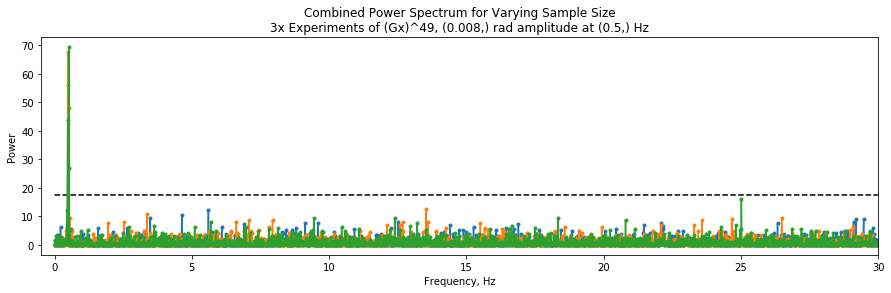

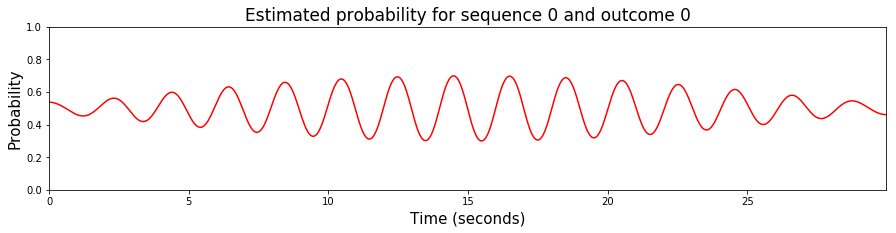

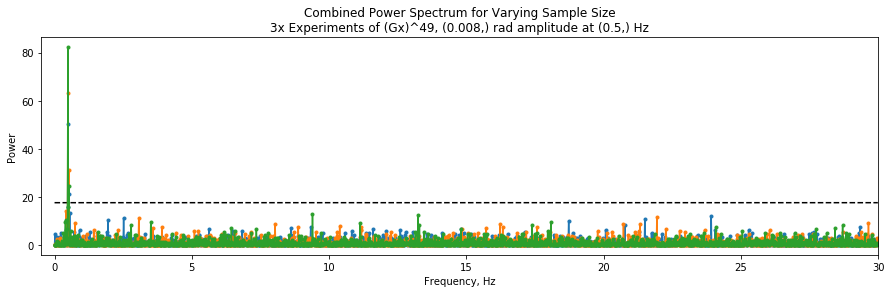

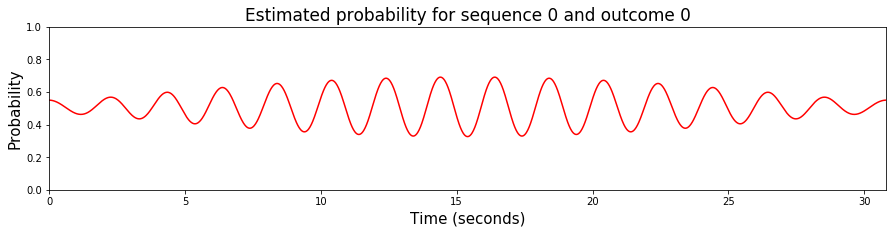

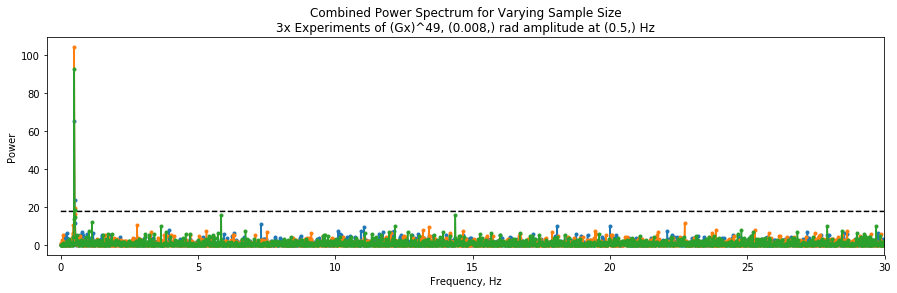

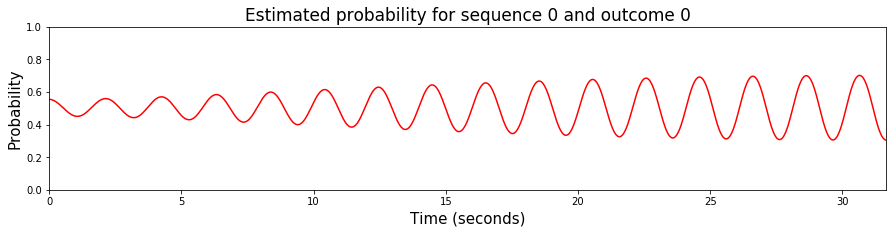

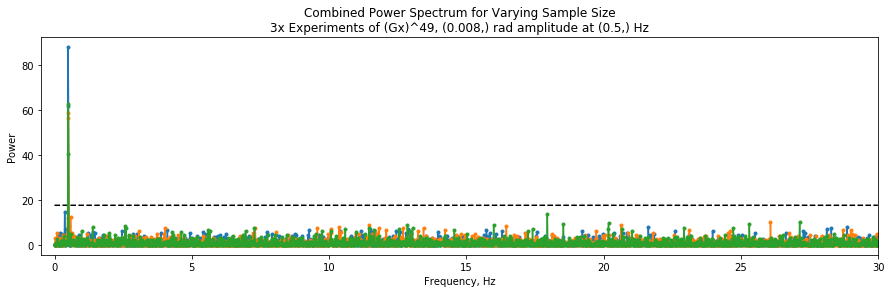

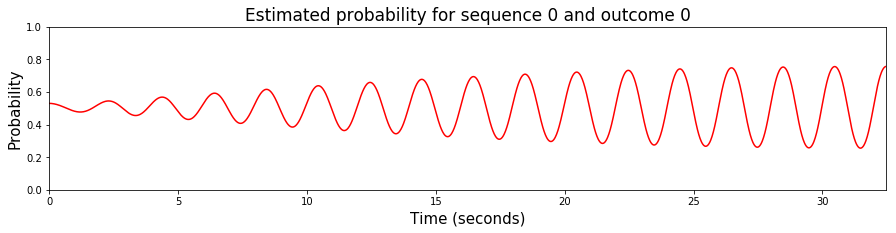

HELLO WORLD


In [10]:
############################ Plot the combined power spectra (plotting together num_experiments for each set of parameters)
for results_list in global_results_list:   
    index = global_results_list.index(results_list) 
    if param_name == "frequency": 
        freq_list = variable_params[index] #not actually a list, this is just the naming convention
        title_string = "Combined Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])
        x_string = "Frequency of Drift, Hz"    
    elif param_name == "nSamples": 
        nSamples = variable_params[index]
        title_string = "Combined Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
        x_string = "Number of Samples, each with {} count and {} s".format(nCounts, time_per_sample)
    elif param_name == "L": 
        gate_string = variable_params[index]
        title_string = "Combined Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
        x_string = "Gate Sequence Length"
    elif param_name == "amp": 
        amp_list = variable_params[index] #not actually a list, just convention
        title_string = "Combined Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
        x_string = "Drift Amplitude, radians"
        
    
    
    fig = plt.figure(figsize=(15,4))
    confidence_is_plotted = False
    for results in results_list:
        #plot the original power spectrum
        plt.plot(results.frequencies,results.pspepo_power_spectrum[0,0,1,:],ls="solid",marker='.')
        if not(confidence_is_plotted):plt.plot(results.frequencies,results.pspepo_significance_threshold_1test*np.ones(results.number_of_timesteps),'k--', 
                  label=str(results.confidence)+' confidence single-test significance threshold')
        confidence_is_plotted = True

    
    plt.xlabel("Frequency, Hz")
    plt.xlim((-0.5,results_list[0].frequencies[-1]))
    plt.ylabel("Power")
    plt.title(title_string)
    plt.show()
    
    results_list[0].plot_most_drifty_probability(0)


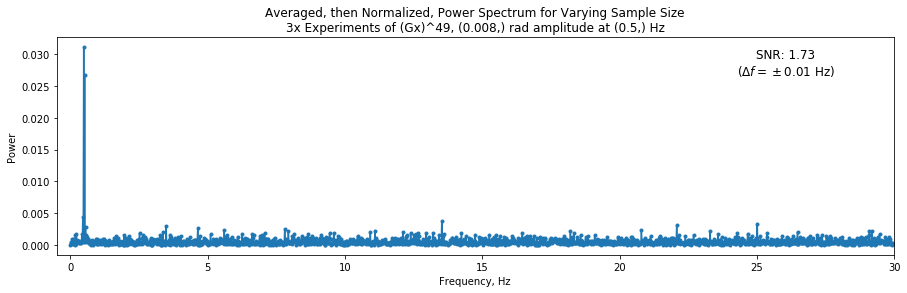

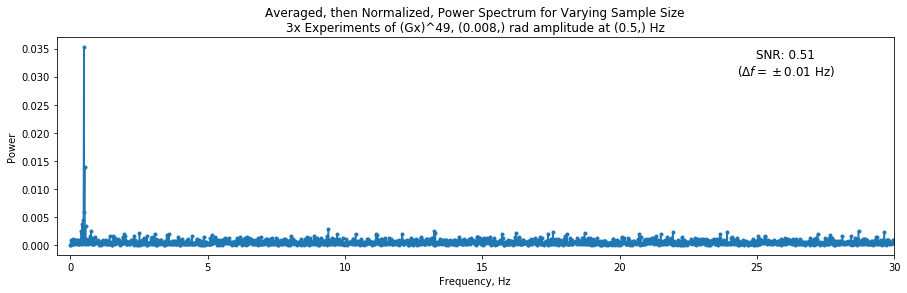

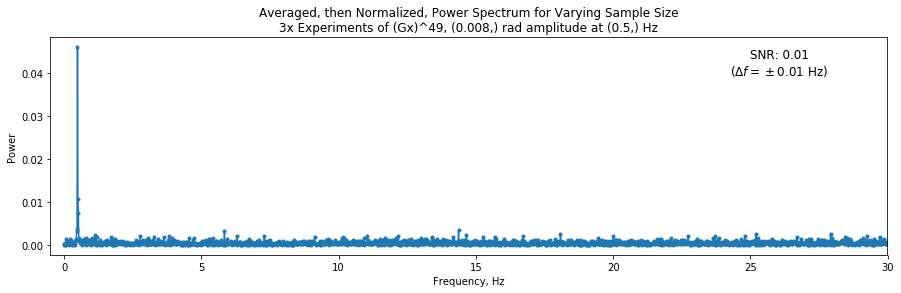

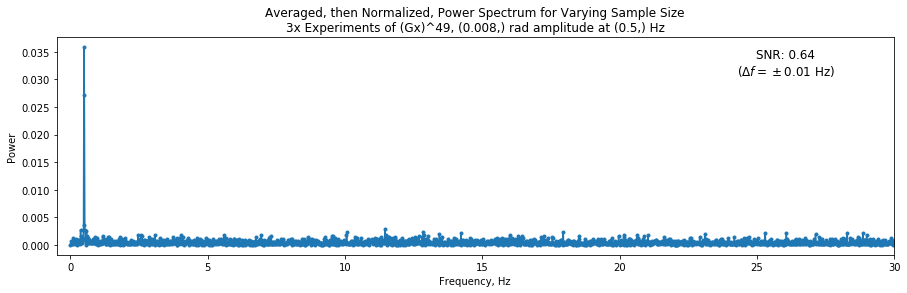

In [13]:
#### Superimpose and average the num_experiments power spectra
#### Normalize the averaged power spectra if necessary
#### also calculate SNR for specified frequency bands

global_snr_list = [0]*num_parameters
for results_list in global_results_list:
    index = global_results_list.index(results_list)
    if param_name == "frequency": 
        freq_list = variable_params[index] #not actually a list, this is just the naming convention
        title_string = "Superimposed Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])
        x_string = "Frequency of Drift, Hz"    
    elif param_name == "nSamples": 
        nSamples = variable_params[index]
        title_string = "Superimposed Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
        x_string = "Number of Samples, each with {} count and {} s".format(nCounts, time_per_sample)
    elif param_name == "L": 
        gate_string = variable_params[index]
        title_string = "Superimposed Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
        x_string = "Gate Sequence Length"
    elif param_name == "amp": 
        amp_list = variable_params[index] #not actually a list, just convention
        title_string = "Superimposed Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
        x_string = "Drift Amplitude, radians"
        
    superimposed_power_spectrum = np.zeros(len(results_list[0].pspepo_power_spectrum[0,0,1,:]))
    superimposed_frequencies = results_list[0].frequencies
    
    for result in results_list:
        #populate the superimposed power spectrum by adding powers from the num_experiments
        for index2 in range(len(superimposed_power_spectrum)):
            power = result.pspepo_power_spectrum[0,0,1,:][index2]
            superimposed_power_spectrum[index2] += power

    
    averaged = True #here I'm dividing the superimposed power by the number of experiments to get an average
    if averaged:
        superimposed_power_spectrum = superimposed_power_spectrum/num_experiments
        title_string = "Averaged " + title_string[13:]
    global_superimposed_lists[index] = superimposed_power_spectrum
    
    normalized = True #here I'm dividing each averaged and superimposed spectrum by its total number of points
    if normalized:
        if not(averaged) and num_experiments > 1:
            print("Must be averaged before it can be normalized!!!")
        else:
            superimposed_power_spectrum = superimposed_power_spectrum/nSamples
            title_string = "Averaged, then Normalized, " + title_string[9:]
            global_normalized_superimposed_lists[index] = superimposed_power_spectrum

            
    avg_SNR = SNR(superimposed_frequencies, superimposed_power_spectrum, snr_freq_list, snr_bandwidth)   
    global_snr_list[index] = avg_SNR
    
    fig = plt.figure(figsize=(15,4))
    plt.plot(superimposed_frequencies, superimposed_power_spectrum,ls="solid",marker='.')
    plt.xlabel("Frequency, Hz")
    plt.xlim((-0.5,superimposed_frequencies[-1]))
    plt.ylabel("Power")
    plt.title(title_string)
    plt.figtext(0.8, 0.75,"SNR: {:.2f}\n$(\Delta f = \pm{}$ Hz)".format(avg_SNR,snr_bandwidth), wrap=True,
            horizontalalignment='center', fontsize=12)
    plt.show()

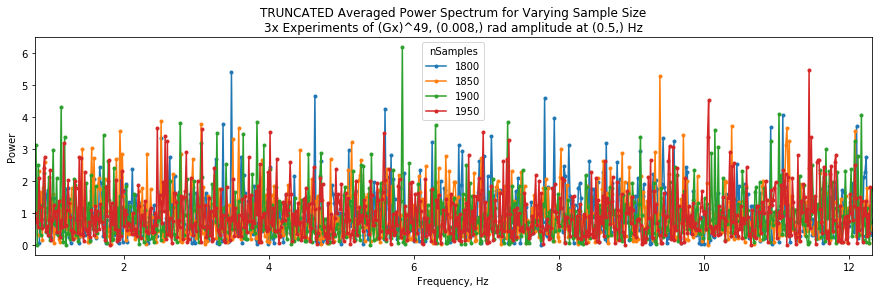

In [14]:
##Plotting the truncated, superimposed power spectrum
plt.figure(figsize=(15,4))
for results_list in global_results_list:
    index = global_results_list.index(results_list)       
    if param_name == "frequency": 
        title_string = "Superimposed Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])   
    elif param_name == "nSamples": 
        title_string = "Superimposed Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
    elif param_name == "L": 
        title_string = "Superimposed Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
    elif param_name == "amp": 
        title_string = "Superimposed Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
    
    superimposed_power_spectrum = np.zeros(len(results_list[0].pspepo_power_spectrum[0,0,1,:]))
    superimposed_frequencies = results_list[0].frequencies
    
    for result in results_list:
        for index3 in range(len(superimposed_power_spectrum)):
            power = result.pspepo_power_spectrum[0,0,1,:][index3]
            superimposed_power_spectrum[index3] += power
    
    averaged = True #here I'm dividing the superimposed power by the number of experiments to get an average
    if averaged:
        superimposed_power_spectrum = superimposed_power_spectrum/num_experiments
        #print("!!!!!! Power is averaged here! Previous saved versions just have the powers summed!")
        title_string = "Averaged " + title_string[13:]
    
    
    mindex = 50
    maxdex = 800
    
    label=variable_params[index]
    legend_string=param_name
    if param_name == "amp":
        label = round(min(variable_params[index]),4)
        legend_string="Min. amp."
    
    plt.plot(superimposed_frequencies[mindex:maxdex], superimposed_power_spectrum[mindex:maxdex],ls="solid",marker='.',
            label=label)

plt.xlabel("Frequency, Hz")
plt.xlim((superimposed_frequencies[mindex],superimposed_frequencies[maxdex]))
plt.ylabel("Power")
plt.title("TRUNCATED " + title_string)
plt.legend(title=legend_string)

plt.show()


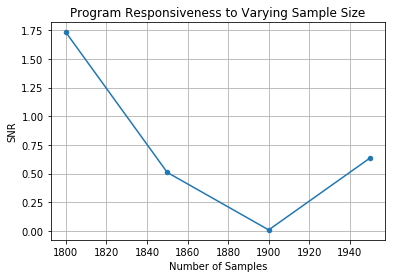

In [15]:
#######here i'll show the results over the varied parameter
index = global_results_list.index(results_list)
x_string = ''
if param_name == "frequency": 
    freq_list = variable_params[index] #not actually a list, this is just the naming convention
    title_string = "Program Responsiveness to Varying Drift Frequencies"
    x_string = "Frequency of Drift, Hz"    
elif param_name == "nSamples": 
    nSamples = variable_params[index]
    title_string = "Program Responsiveness to Varying Sample Size"
    x_string = "Number of Samples"
elif param_name == "L": 
    gate_string = variable_params[index]
    title_string = "Program Responsiveness to Varying Gate Length"
    x_string = "Gate Sequence Length"
elif param_name == "amp": 
    amp_list = variable_params[index] #not actually a list, just convention
    title_string = "Program Responsiveness to Varying Sine Error Amplitude"
    x_string = "Minimum Drift Amplitude, radians"
    
#print(variable_params)
#print(global_snr_list)
if param_name != "amp" or special_amp_params == False:
    plt.plot(variable_params,global_snr_list, marker='.',markersize="9")
elif param_name == "amp" and special_amp_params:
    modified_params = [0]*len(variable_params)
    for index4 in range(len(variable_params)):
        modified_params[index4] = min(variable_params[index4])
    plt.plot(modified_params,global_snr_list, marker='.',markersize="9")
    if low_incr <= 0:
        zero_index = abs(low_incr)
        base_amp_val = min(variable_params[zero_index])
        base_amp_snr = global_snr_list[zero_index]
        plt.plot(base_amp_val, base_amp_snr, label="Nominal Amp.", markersize="10", marker='.', ls='None')
        plt.legend()
    plt.xticks(rotation=90)
plt.grid()
plt.xlabel(x_string)
plt.title(title_string)
plt.ylabel("SNR")
plt.show()

In [16]:
#show total rotation angle as a function of time if the varied parameter is L
if param_name == "L":
    lower_i = 0
    upper_i = 1999
    
    plt.figure(figsize=(15,4))
    for list_index in range(0, num_parameters, 5):
        L = variable_params[list_index]
        print("For L value: {}".format(L))
        angle_list = global_angle_list[list_index]
        print(angle_list)
        ideal_angle_list = global_angle_list[list_index]
        times = global_timestamps_list[list_index]
        #plt.plot(times, ideal_angle_list, ls='dashed', label="Ideal")
        plt.plot(times, angle_list, marker='.', label=L)
    plt.title("Time-Dependent Rotation from L-gates")
    plt.plot(times, [np.pi/2]*len(times), ls="dashed", label="Ideal Pi/2")
    plt.xlabel("Time, seconds")
    plt.yticks(np.linspace(0, np.pi, 5), ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    plt.xlim(times[lower_i], times[upper_i])
    plt.ylabel("Angle, radians\n(Displayed between 0 and $\pi$)")
    plt.legend(loc="lower right",title="L")
    plt.show()

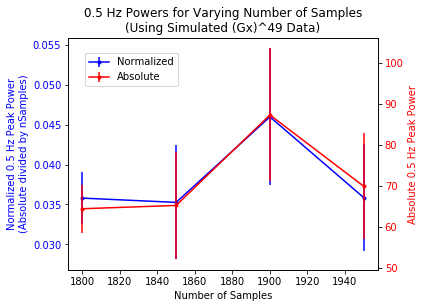

Distribution of Normalized Powers:
Mean: 0.0382
Std. Dev: 0.0000

**Uses 4 powers to determine this, where each power is
obtained by normalizing the power spectra of 3 identical experiments,
finding the peak of those normalized spectra, and then averaging those 3 powers.
The standard deviation is the standard deviation of these 4 peak powers


In [20]:
############ Showing the total power spectrum and power of 1.2 Hz peak if parameter is sample size
'''fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Sample size (number of input data points)")
ax1.set_ylabel('{} Hz Peak Power'.format(freq_of_interest), color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(variable_params, global_avg_peak_power_list, marker='.',label="{} Hz".format(freq_of_interest), color='blue')
ax2.set_ylabel('Spectrum Total Power', color="red")
ax2.plot(variable_params, np.asarray(global_avg_total_power_list), marker='.', label="Total Spectrum", color="red")
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
fig.legend(loc=(0.15, 0.72))
plt.title("Power Spectrum for Varying Sample Size\n(Using Simulated {} Data)".format(gate_string))
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(variable_params, global_avg_total_power_list)
#print("Slope is {:.1f} power units per number of input points".format(slope))
#print("Total Power = {:.3f}*num_points + {:.3f}".format(slope, intercept))'''
##### Doing normalized spectrum
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel(x_string)
ax1.set_ylabel('Normalized {} Hz Peak Power\n(Absolute divided by nSamples)'.format(freq_of_interest), color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.errorbar(variable_params, global_avg_normalized_peak_power_list, yerr=global_std_dev_normalized_peak_power_list,\
             marker='.',label="Normalized".format(freq_of_interest), color='blue', fmt='-o')
ax2.set_ylabel('Absolute {} Hz Peak Power'.format(freq_of_interest), color="red")
ax2.errorbar(variable_params, global_avg_peak_power_list, yerr=global_std_dev_peak_power_list,\
             marker='.', label="Absolute", color="red", fmt='-o')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
fig.legend(loc=(0.2, 0.72))
plt.title("{} Hz Powers for Varying {}\n(Using Simulated {} Data)".format(freq_of_interest, x_string, gate_string))
plt.show()

print("Distribution of Normalized Powers:")
print("Mean: {:.4f}".format(np.mean(global_avg_normalized_peak_power_list))) #takes the mean of the mean power per parameter set
print("Std. Dev: {:.4f}".format(np.std(np.mean(global_avg_normalized_peak_power_list)))) #takes the std dev of the above value
print("\n**Uses {} powers to determine this, where each power is\nobtained by normalizing the power spectra of {} identical experiments,\nfinding the peak of those normalized spectra, and then averaging those {} powers.".format(num_parameters, num_experiments, num_experiments))
print("The standard deviation is the standard deviation of these {} peak powers".format(num_parameters))